# 차선인식

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

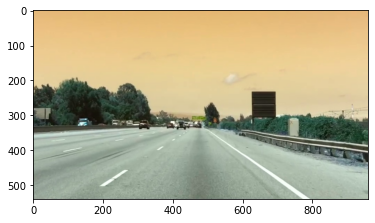

In [6]:
image = cv2.imread('./data/test.jpg')
plt.imshow(image)

## Color Selection 

Color Picker Tool로 해당 이미지 색상의 RGB 코드값 얻어오기
https://annystudio.com/software/colorpicker/#download

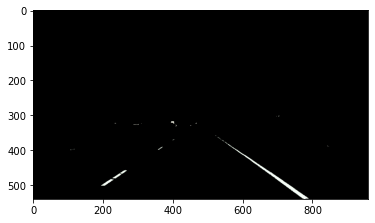

In [26]:
color_select = np.copy(image)

red_threshold = 237
green_threshold = 237
blue_threshold = 237


color_threshold = ((image[:, :, 0] < red_threshold) |
                   (image[:, :, 1] < green_threshold) |
                   (image[:, :, 2] < blue_threshold))

color_select[color_threshold] = [0, 0, 0]
plt.imshow(color_select)

## Region Selection

In [27]:
image.shape

(540, 960, 3)

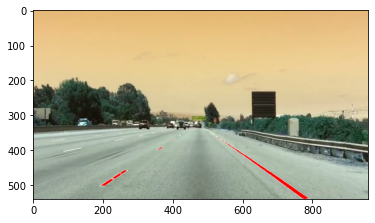

In [61]:
color_select = np.copy(image)

red_threshold = 237
green_threshold = 237
blue_threshold = 237


color_threshold = ((image[:, :, 0] < red_threshold) |
                   (image[:, :, 1] < green_threshold) |
                   (image[:, :, 2] < blue_threshold))

color_select[color_threshold] = [0, 0, 0]

# 2. Region Selection
region_select = np.copy(image)

left_button = [0, 540]
right_button = [960, 540]
apex = [475, 330]

pts = np.array([left_button, right_button, apex])
cv2.fillPoly(region_select, [pts], color = [0, 0, 255])

region_threshold = ((region_select[:, :, 0] == 0) &    # R channel
                    (region_select[:, :, 1] == 0) &    # G channel
                    (region_select[:, :, 2] == 255))   # B channel


# 3 Color Selection + Region Selection
# color_threshold: 차선(흰색)이 아닌 부분 True 설정
# region_threshold: 관심영역(region of interes, roi)에만 True 설정
lane_select = np.copy(image)
lane_select[~color_threshold > 0] = [255, 0, 0]

plt.imshow(lane_select)

In [59]:
~color_threshold

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

## Color and Region Selection

## Canny Edge Detection

## ROI Selection

## Hough Transform

## Pipeline
- Canny Detection -> ROI Selection -> Hough Transform